Epoch[1/25], G Loss: 2.4915, D Loss: 0.4231


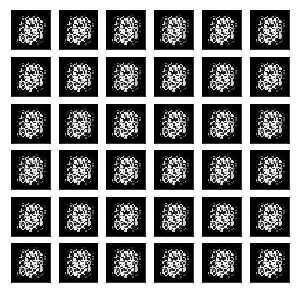

Epoch[2/25], G Loss: 3.0411, D Loss: 0.1381


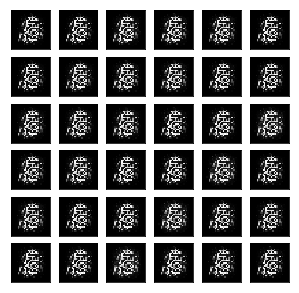

Epoch[3/25], G Loss: 3.0596, D Loss: 0.1653


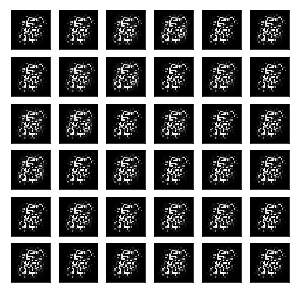

Epoch[4/25], G Loss: 3.3639, D Loss: 0.1571


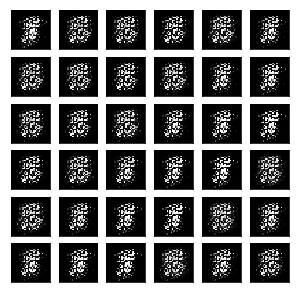

Epoch[5/25], G Loss: 3.7481, D Loss: 0.0998


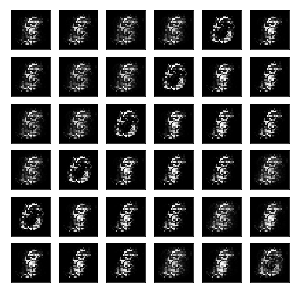

Epoch[6/25], G Loss: 2.1302, D Loss: 0.4139


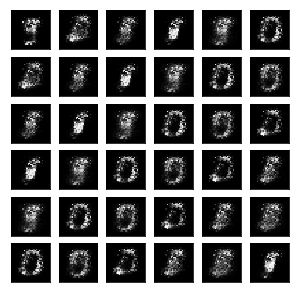

Epoch[7/25], G Loss: 2.2363, D Loss: 0.3836


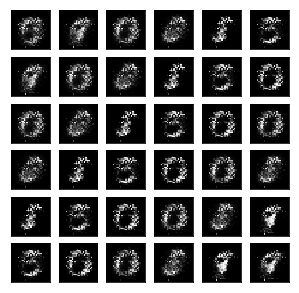

Epoch[8/25], G Loss: 2.4970, D Loss: 0.4103


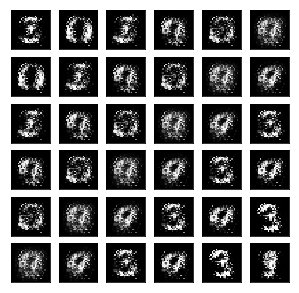

Epoch[9/25], G Loss: 2.8206, D Loss: 0.2961


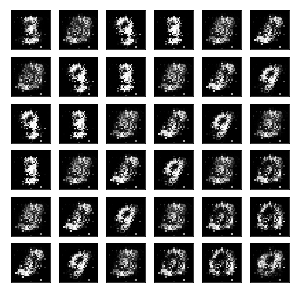

Epoch[10/25], G Loss: 2.8508, D Loss: 0.3158


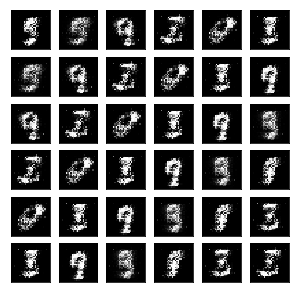

Epoch[11/25], G Loss: 2.5178, D Loss: 0.3645


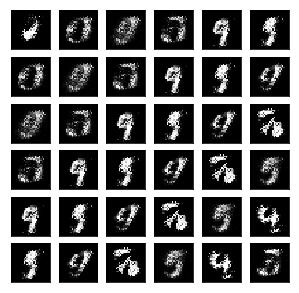

Epoch[12/25], G Loss: 2.5417, D Loss: 0.3189


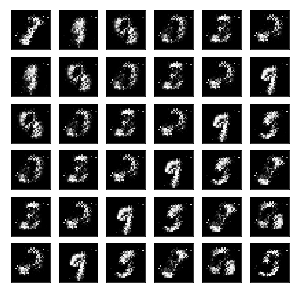

Epoch[13/25], G Loss: 2.7001, D Loss: 0.2967


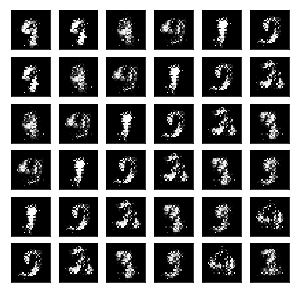

Epoch[14/25], G Loss: 3.1001, D Loss: 0.2594


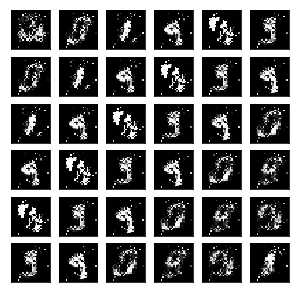

Epoch[15/25], G Loss: 3.3485, D Loss: 0.2404


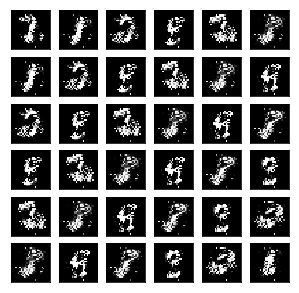

Epoch[16/25], G Loss: 3.3261, D Loss: 0.2600


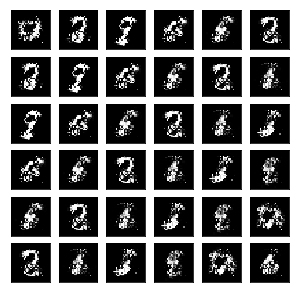

Epoch[17/25], G Loss: 3.0748, D Loss: 0.3326


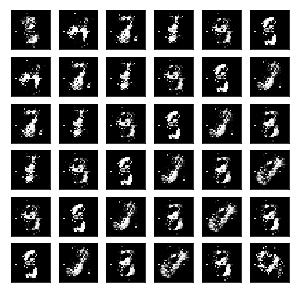

Epoch[18/25], G Loss: 3.1650, D Loss: 0.2715


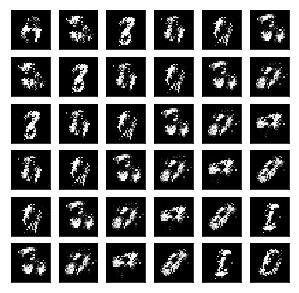

Epoch[19/25], G Loss: 3.4007, D Loss: 0.2961


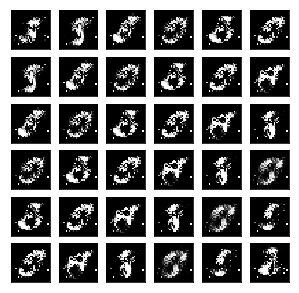

Epoch[20/25], G Loss: 3.4345, D Loss: 0.2919


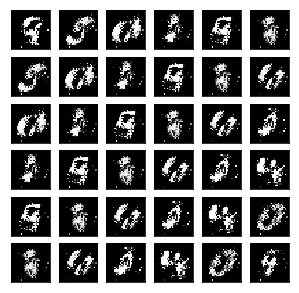

Epoch[21/25], G Loss: 3.4580, D Loss: 0.2818


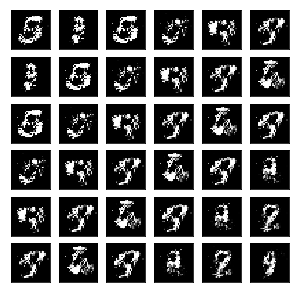

Epoch[22/25], G Loss: 3.2562, D Loss: 0.3212


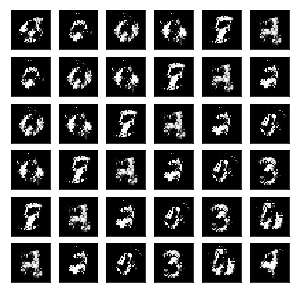

Epoch[23/25], G Loss: 3.3668, D Loss: 0.2664


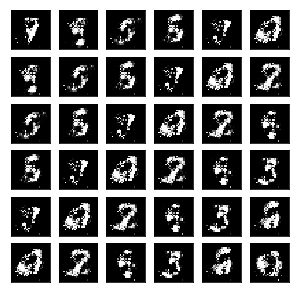

Epoch[24/25], G Loss: 3.5192, D Loss: 0.2557


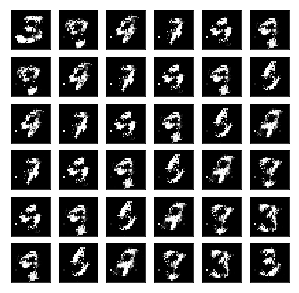

Epoch[25/25], G Loss: 3.5314, D Loss: 0.2644


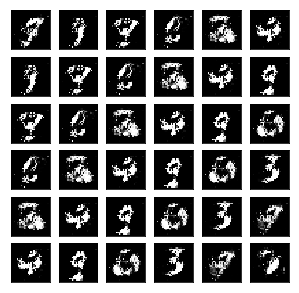

In [1]:
""" (BayesGAN)

From the authors:
"
Bayesian GAN (Saatchi and Wilson, 2017) is a Bayesian formulation of Generative 
Adversarial Networks (Goodfellow, 2014) where we learn the distributions of the 
generator parameters $\theta_g$ and the discriminator parameters $\theta_d$ 
instead of optimizing for point estimates. The benefits of the Bayesian approach 
include the flexibility to model multimodality in the parameter space, as well 
as the ability to prevent mode collapse in the maximum likelihood (non-Bayesian) 
case.

We learn Bayesian GAN via an approximate inference algorithm called Stochastic 
Gradient Hamiltonian Monte Carlo (SGHMC) which is a gradient-based MCMC methods 
whose samples approximate the true posterior distributions of $\theta_g$ and 
$\theta_d$. The Bayesian GAN training process starts from sampling noise $z$ 
from a fixed  distribution(typically standard d-dim normal). The noise is fed 
to the generator where the parameters  $\theta_g$ are sampled from the posterior 
distribution $p(\theta_g | D)$. The generated  image given the parameters 
$\theta_g$ ($G(z|\theta_g)$) as well as the real data are presented to the 
discriminator, whose parameters are sample from its posterior 
distribution $p(\theta_d|D)$. We update the posteriors using the gradients 
$\frac{\partial \log p(\theta_g|D) }{\partial \theta_g }$ and 
$\frac{\partial \log p(\theta_d|D) }{\partial \theta_d }$ with 
Stochastic Gradient Hamiltonian Monte Carlo (SGHMC)."

SGHMC is fancy for using point estimates (as in most GANs) to infer the 
posteriors.

https://arxiv.org/pdf/1705.09558.pdf
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook


def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = torch.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Discriminator. Input is an image (real or generated), output is P(generated).
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = torch.sigmoid(self.discriminate(activated))
        return discrimination


class BayesGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim

    
# class BayesGANTrainer:
#     """ Object to hold data iterators, train a GAN variant 
#     """
#     def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
#         self.model = to_cuda(model)
#         self.name = model.__class__.__name__
        
#         self.train_iter = train_iter
#         self.val_iter = val_iter
#         self.test_iter = test_iter
        
#         self.Glosses = []
#         self.Dlosses = []
        
#         self.viz = viz
            
#     def train(self, num_epochs, G_lr=2e-4, D_lr=2e-4, D_steps=1):
#         """ Train a vanilla GAN using the non-saturating gradients loss for the generator. 
#             Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

#         Inputs:
#             num_epochs: int, number of epochs to train for
#             G_lr: float, learning rate for generator's Adam optimizer (default 2e-4)
#             D_lr: float, learning rate for discriminator's Adam optimizer (default 2e-4)
#             D_steps: int, training step ratio for how often to train D compared to G (default 1)
#         """
#         # Initialize optimizers
#         G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
#         D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
#         # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
#         epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
#         # Begin training
#         for epoch in tqdm_notebook(range(1, num_epochs+1)):
#             self.model.train()
#             G_losses, D_losses = [], []
            
#             for _ in range(epoch_steps):
                
#                 D_step_loss = []
                
#                 for _ in range(D_steps): 

#                     # Reshape images
#                     images = self.process_batch(self.train_iter)

#                     # TRAINING D: Zero out gradients for D
#                     D_optimizer.zero_grad()

#                     # Train the discriminator to learn to discriminate between real and generated images
#                     D_loss = self.train_D(images)
                    
#                     # Update parameters
#                     D_loss.backward()
#                     D_optimizer.step()
                    
#                     # Log results, backpropagate the discriminator network
#                     D_step_loss.append(D_loss.item())
                                                        
#                 # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
#                 D_losses.append(np.mean(D_step_loss))
                
#                 # TRAINING G: Zero out gradients for G
#                 G_optimizer.zero_grad()

#                 # Train the generator to generate images that fool the discriminator
#                 G_loss = self.train_G(images)
                
#                 # Log results, update parameters
#                 G_losses.append(G_loss.item())
#                 G_loss.backward()
#                 G_optimizer.step()
            
#             # Save progress
#             self.Glosses.extend(G_losses)
#             self.Dlosses.extend(D_losses)
                            
#             # Progress logging
#             print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
#                    %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
#             self.num_epochs = epoch
            
#             # Visualize generator progress
#             self.generate_images(epoch)
            
#             if self.viz:
#                 plt.show()
                
#     def train_D(self, images):
#         """ Run 1 step of training for discriminator

#         Input:
#             images: batch of images (reshaped to [batch_size, 784])
#         Output:
#             D_loss: non-saturing loss for discriminator, 
#             -E[log(D(x))] - E[log(1 - D(G(z)))]
#         """    
#         # Generate labels (ones indicate real images, zeros indicate generated)
#         X_labels = to_cuda(torch.ones(images.shape[0], 1)) 
#         G_labels = to_cuda(torch.zeros(images.shape[0], 1)) 
        
#         # Classify the real batch images, get the loss for these 
#         DX_score = self.model.D(images)
#         DX_loss = F.binary_cross_entropy(DX_score, X_labels)
        
#         # Sample noise z, generate output G(z)
#         noise = self.compute_noise(images.shape[0], model.z_dim)
#         G_output = self.model.G(noise)
        
#         # Classify the fake batch images, get the loss for these using sigmoid cross entropy
#         DG_score = self.model.D(G_output)
#         DG_loss = F.binary_cross_entropy(DG_score, G_labels)
        
#         # Compute vanilla (original paper) D loss
#         D_loss = DX_loss + DG_loss
        
#         return D_loss
    
#     def train_G(self, images):
#         """ Run 1 step of training for generator
        
#         Input:
#             images: batch of images reshaped to [batch_size, -1]    
#         Output:
#             G_loss: non-saturating loss for how well G(z) fools D, 
#             -E[log(D(G(z)))]
#         """        
#         # Generate labels for the generator batch images (all 0, since they are fake)
#         G_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        
#         # Get noise (denoted z), classify it using G, then classify the output of G using D.
#         noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
#         G_output = self.model.G(noise) # G(z)
#         DG_score = self.model.D(G_output) # D(G(z))
        
#         # Compute the non-saturating loss for how D did versus the generations of G using sigmoid cross entropy
#         G_loss = F.binary_cross_entropy(DG_score, G_labels)
        
#         return G_loss
    
#     def compute_noise(self, batch_size, z_dim):
#         """ Compute random noise for the generator to learn to make images from """
#         return to_cuda(torch.randn(batch_size, z_dim))
    
#     def process_batch(self, iterator):
#         """ Generate a process batch to be input into the discriminator D """
#         images, _ = next(iter(iterator))
#         images = to_cuda(images.view(images.shape[0], -1))
#         return images
    
#     def generate_images(self, epoch, num_outputs=36, save=True):
#         """ Visualize progress of generator learning """
#         # Turn off any regularization
#         self.model.eval()
        
#         # Sample noise vector
#         noise = self.compute_noise(num_outputs, self.model.z_dim)
        
#         # Transform noise to image
#         images = self.model.G(noise)
        
#         # Reshape to proper image size
#         images = images.view(images.shape[0], 28, 28)
        
#         # Plot
#         plt.close()
#         size_figure_grid = int(num_outputs**0.5)
#         fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
#         for i, j in product(range(size_figure_grid), range(size_figure_grid)):
#             ax[i,j].get_xaxis().set_visible(False)
#             ax[i,j].get_yaxis().set_visible(False)
#             ax[i,j].cla()
#             ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
#         # Save images if desired
#         if save:
#             outname = '../viz/' + self.name + '/'
#             if not os.path.exists(outname):
#                 os.makedirs(outname)
#             torchvision.utils.save_image(images.unsqueeze(1).data, 
#                                          outname + 'reconst_%d.png'
#                                          %(epoch), nrow = 5)
    
#     def viz_loss(self):
#         """ Visualize loss for the generator, discriminator """
#         # Set style, figure size
#         plt.style.use('ggplot')
#         plt.rcParams["figure.figsize"] = (8,6)

#         # Plot Discriminator loss in red, Generator loss in green
#         plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
#         plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
#         # Add legend, title
#         plt.legend(['Discriminator', 'Generator'])
#         plt.title(self.name)
#         plt.show()

#     def save_model(self, savepath):
#         """ Save model state dictionary """
#         torch.save(self.model.state_dict(), savepath)
    
#     def load_model(self, loadpath):
#         """ Load state dictionary into model """
#         state = torch.load(loadpath)
#         self.model.load_state_dict(state)


# model = BayesGAN(image_size=784, 
#               hidden_dim=256, 
#               z_dim=128)

# trainer = BayesGANTrainer(model=model, 
#                        train_iter=train_iter, 
#                        val_iter=val_iter, 
#                        test_iter=test_iter,
#                        viz=True)

# trainer.train(num_epochs=25, 
#               G_lr=2e-4, 
#               D_lr=2e-4, 
#               D_steps=1)